In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

In [3]:
def mask(df, function, column_name):
    return df[function(df[column_name])]

# Data preparation

In [4]:
movies = pd.read_csv(Path('..','res','data2','movies.csv'))
ratings = pd.read_csv(Path('..','res','data2','ratings.csv'))
users = pd.read_csv(Path('..','res','data2','users.csv'))

#set id's to start from 0
movies['movie_id'] = movies['movie_id'].apply(lambda x: str(x-1))
users['user_id'] = users['user_id'].apply(lambda x: str(x-1))
ratings['movie_id'] = ratings['movie_id'].apply(lambda x: str(x-1))
ratings['user_id'] = ratings['user_id'].apply(lambda x: str(x-1))

## add a year column
movies['year'] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

## rating to float
ratings['rating'] = ratings['rating'].apply(lambda x: float(x))



In [5]:
genre_cols = [
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

In [6]:
# compute how many movies is assigned to a specific genre
genre_occurences = movies[genre_cols].sum().to_dict()

In [7]:
sum(genre_occurences.values()), movies.shape[0]

(2893, 1682)

In [8]:
movies.columns

Index(['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
       'unknown', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'year'],
      dtype='object')

In [9]:
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [10]:
# [movies[genre] for genre in genre_cols] tworzy listę kolumn gatunków
# *sprawia, że zip potraktuje każdy element listy oddzielnie
# zip łączy pierwsze elementty ze sobą, drugie elementy ze sobą itd
# więc powstaje lista tupelek, gdzie każda tupelka jest jak wiersz wyciąty 
# z dataframe

def get_gender(movie_genres_status, action_type):
    genre_and_status = [i for i in zip(genre_cols, movie_genres_status)]
    active_genres = [genre for genre, status in genre_and_status if status == 1]
    if len(active_genres) == 0:
        return("Other")
    else:
        if action_type == 'all':
            return '-'.join(active_genres)
        if action_type == 'random':
            random_genre = np.random.choice(active_genres)
            return random_genre

def add_genre_columns():
    #transfom an extract of dataframe with genres to a list of tuples
    tuples_list = [k for k in zip(*[movies[genre] for genre in genre_cols])]
    
    movies['random_genre'] = [get_gender(genres_row, 'random') for genres_row in tuples_list]
    movies['all_genres'] = [get_gender(genres_row, 'all') for genres_row in tuples_list]
    
add_genre_columns()

In [11]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [12]:
def create_test_training(dataframe, test_fraction):
    test = dataframe.sample(frac = test_fraction, replace = False,
                           axis = 0, random_state = 123) #False means without0 replacement
    training = dataframe[~dataframe.index.isin(test.index)]
    return test, training
create_test_training(movielens, 0.2)[0].shape

(20000, 35)

# Exploring dataset

In [13]:
users.describe(include=[object])

,user_id,gender,occupation,zip_code
count,943,943,943,943
unique,943,2,21,795
top,0,M,student,55414
freq,1,670,196,9


In [14]:
users.describe()

,age
count,943.000
mean,34.052
std,12.193
min,7.000
25%,25.000
50%,31.000
75%,43.000
max,73.000


In [15]:
movies.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000,1682.000
mean,NaN,0.001,0.149,0.080,0.025,0.073,0.300,0.065,0.030,0.431,0.013,0.014,0.055,0.033,0.036,0.147,0.060,0.149,0.042,0.016
std,NaN,0.034,0.356,0.272,0.156,0.259,0.458,0.246,0.170,0.495,0.114,0.119,0.227,0.179,0.187,0.354,0.238,0.356,0.201,0.126
min,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,NaN,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,NaN,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [16]:
movies.describe(include = [object])

,movie_id,title,release_date,IMDb_URL,year,genre,all_genres,random_genre
count,1682,1682,1681,1679,1682,1682,1682,1682
unique,1682,1664,240,1660,72,19,216,19
top,0,"Designated Mourner, The (1997)",01-Jan-1995,http://us.imdb.com/M/title-exact?Designated%20...,1996,Drama,Drama,Drama
freq,1,2,215,2,355,540,376,535


In [17]:
ratings.describe()

,rating,timestamp
count,100000.000,100000.000
mean,3.530,883528851.489
std,1.126,5343856.190
min,1.000,874724710.000
25%,3.000,879448709.500
50%,4.000,882826944.000
75%,4.000,888259984.000
max,5.000,893286638.000


In [18]:
ratings.describe(include=[object])

,user_id,movie_id
count,100000,100000
unique,943,1682
top,404,49
freq,737,583


__Observations__:
* some titles appears more than once
* there are the most dramats in the database
* most of viewers rate movies as 4 or higher

## Plots

<Axes: ylabel='Frequency'>

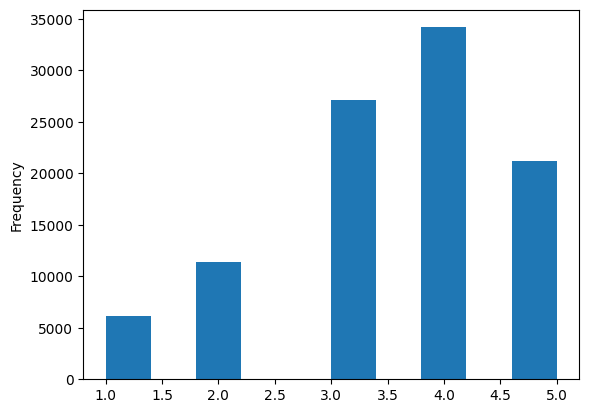

In [19]:
ratings['rating'].plot(kind='hist')

<Axes: ylabel='Frequency'>

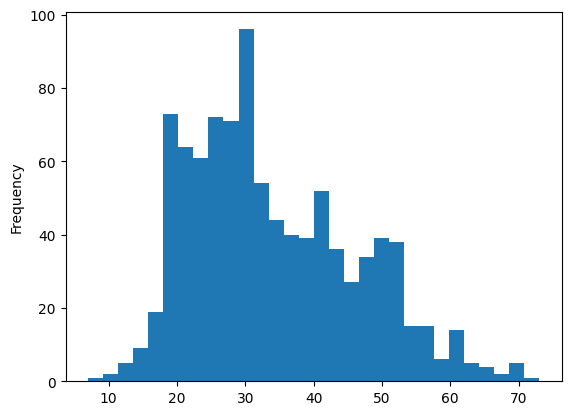

In [20]:
users['age'].plot(kind='hist', bins=30)

Text(0.5, 1.0, 'Rozkład wieku użytkowników')

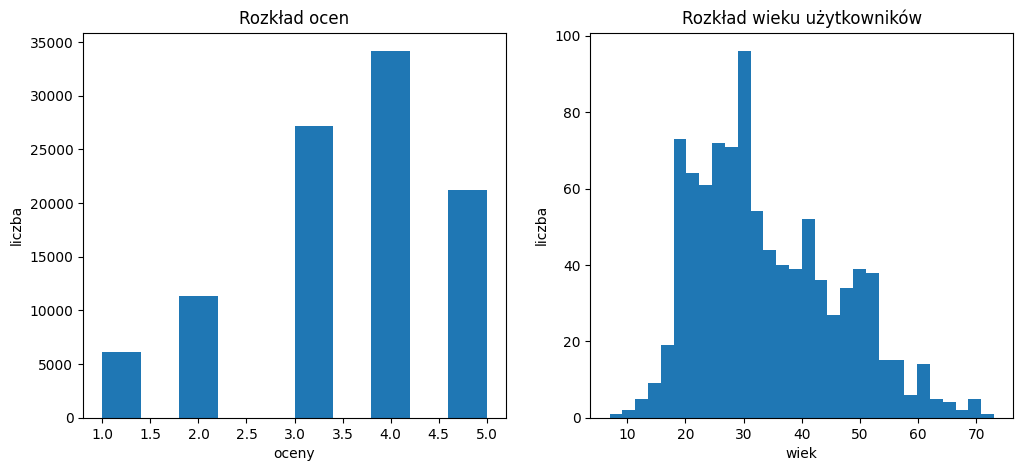

In [21]:
plt.figure(figsize=(12, 5))

# Pierwszy subplot - histogram wieku
plt.subplot(1, 2, 1)
ratings['rating'].plot(kind='hist')
plt.xlabel('oceny')
plt.ylabel('liczba')
plt.title('Rozkład ocen')

plt.subplot(1, 2, 2)
users['age'].plot(kind='hist', bins=30)
plt.xlabel('wiek')
plt.ylabel('liczba')
plt.title('Rozkład wieku użytkowników')


In [22]:
#spłaszczanie wielopoziomowych nazw kolumn
def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.flatten_cols = flatten_cols

users_ratings = (
    ratings
    .groupby('user_id', as_index=False) #user_id won't be an index column
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

In [23]:
users_ratings

,user_id,rating count,rating mean,age,gender,occupation,zip_code
0,0,272,3.610,24,M,technician,85711
1,1,62,3.710,53,F,other,94043
2,10,181,3.464,39,F,other,30329
3,100,67,2.896,15,M,student,05146
4,101,216,2.616,38,M,programmer,30220
...,...,...,...,...,...,...,...
938,95,56,4.268,25,F,artist,75206
939,96,63,4.159,43,M,artist,98006
940,97,27,3.593,49,F,executive,90291
941,98,136,3.551,20,M,student,63129


Text(0.5, 1.0, 'Histogram średnich ocen dla programistów')

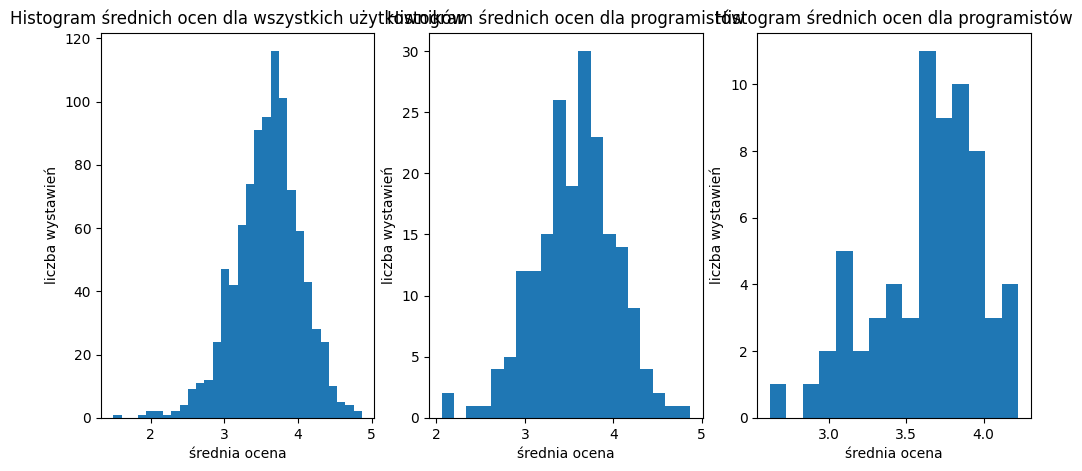

In [24]:
plt.figure(figsize=(12, 5))
students = users_ratings[users_ratings['occupation'] == 'student']
programmers = users_ratings[users_ratings['occupation'] == 'programmer']

plt.subplot(1, 3, 1)
users_ratings['rating mean'].plot(kind='hist', bins = 30)
plt.xlabel('średnia ocena')
plt.ylabel('liczba wystawień')
plt.title("Histogram średnich ocen dla wszystkich użytkowników")

plt.subplot(1, 3, 2)
students['rating mean'].plot(kind='hist', bins=20)
plt.xlabel('średnia ocena')
plt.ylabel('liczba wystawień')
plt.title("Histogram średnich ocen dla programistów")

plt.subplot(1, 3, 3)
programmers['rating mean'].plot(kind='hist', bins = 15)
plt.xlabel('średnia ocena')
plt.ylabel('liczba wystawień')
plt.title("Histogram średnich ocen dla programistów")


In [25]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id')
    .agg({'rating':['count','mean']})
    .flatten_cols(),
    on='movie_id'
)

In [26]:
movies_ratings

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Sci-Fi,Thriller,War,Western,year,genre,all_genres,random_genre,rating count,rating mean
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,1995,Comedy,Animation-Children's-Comedy,Animation,452,3.878
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,1,0,0,1995,Adventure,Action-Adventure-Thriller,Adventure,131,3.206
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,1,0,0,1995,Thriller,Thriller,Thriller,90,3.033
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,1995,Action,Action-Comedy-Drama,Drama,209,3.550
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,1,0,0,1995,Drama,Crime-Drama-Thriller,Crime,86,3.302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,1998,Drama,Drama,Drama,1,1.000
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,1,0,0,1998,Romance,Romance-Thriller,Thriller,1,3.000
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1998,Romance,Drama-Romance,Romance,1,2.000
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,1994,Comedy,Comedy,Comedy,1,3.000


Text(0.5, 1.0, 'Histogram średnich ocen dla komedii')

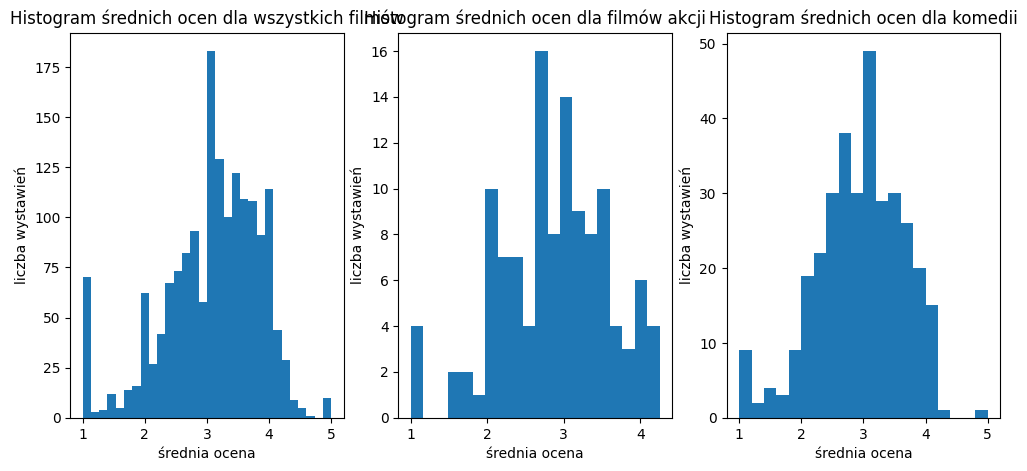

In [27]:
plt.figure(figsize=(12, 5))
actions = movies_ratings[movies_ratings['random_genre'] == 'Action']
comedies = movies_ratings[movies_ratings['random_genre'] == 'Comedy']

plt.subplot(1, 3, 1)
movies_ratings['rating mean'].plot(kind='hist', bins = 30)
plt.xlabel('średnia ocena')
plt.ylabel('liczba wystawień')
plt.title("Histogram średnich ocen dla wszystkich filmów")

plt.subplot(1, 3, 2)
actions['rating mean'].plot(kind='hist', bins=20)
plt.xlabel('średnia ocena')
plt.ylabel('liczba wystawień')
plt.title("Histogram średnich ocen dla filmów akcji")

plt.subplot(1, 3, 3)
comedies['rating mean'].plot(kind='hist', bins = 20)
plt.xlabel('średnia ocena')
plt.ylabel('liczba wystawień')
plt.title("Histogram średnich ocen dla komedii")


## Create sparse rating matrix A

In [28]:
def build_tensor(ratings, users, movies):
    indices = ratings[['user_id','movie_id']].values
    values = ratings['rating'].values
    dense_shape = [users.shape[0],movies.shape[0]]
    
    tensor = tf.SparseTensor(indices=indices, 
                             values=values, 
                             dense_shape=dense_shape)
    return tensor

## Count MSE
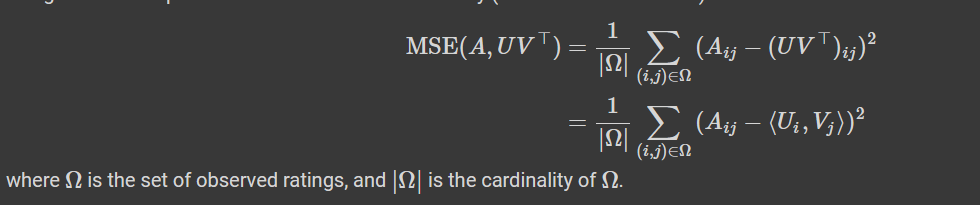

In [29]:
def caltulate_mse(rating_tensor, user_matrix, movie_matrix, rating_df):
    predictions = tf.matmul(user_matrix, movie_matrix, transpose_b=True)
    not_null_predictions = tf.gather_nd(predictions, rating_tensor.indices)
    MSE = tf.losses.mean_squared_error(rating_tensor.values, predictions)
    

# Train a model

In [30]:
class CFModel:
    def ___init__(self, embedding_vars, loss, metrics = None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self.__session = None
        
    def embeddings(self):
        return self._embeddings
    
    def train(self, iterations_num = 100, learning_rate = 1.0, 
              plot_result = True, optimizer = tf.train.GradientDescentOptimizer):
        
        

SyntaxError: incomplete input (360540837.py, line 15)